In [1]:
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import scienceplots

In [2]:
df1 = pd.read_csv('./project_pipeline/data/two-state_cf_pdb_compared.tsv', sep='\t')
df2 = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')

In [3]:
df1.head()

,uniprot,pdb,cluster,region_1,region_2,complex_rmsd,1.0_aligned,1.0_comp,1.1_aligned,1.1_comp,...,2.2_aligned,2.2_comp,2.3_aligned,2.3_comp,1_aligned,1_comp,2_aligned,2_comp,state,conformation
0,O08967,2r09,U10-005,"251-265,383-395",77-206,17.274,0.0,0.0,5.393,41.776,...,0.0,0.0,0,0,3.704,36.530,1.183,33.607,Autoinhibited,Closed
1,O08967,2r09,031,"251-265,383-395",77-206,19.503,0.0,0.0,4.997,33.114,...,0.0,0.0,0,0,3.394,36.860,3.580,31.059,Autoinhibited,Closed
2,O08967,2r09,U10-001,"251-265,383-395",77-206,16.866,0.0,0.0,4.727,19.795,...,0.0,0.0,0,0,3.276,24.538,1.148,23.513,Autoinhibited,Closed
3,O08967,2r09,U100-004,"251-265,383-395",77-206,21.285,0.0,0.0,5.300,38.422,...,0.0,0.0,0,0,3.414,51.587,1.331,52.734,Autoinhibited,Closed
4,O08967,2r09,029,"251-265,383-395",77-206,12.546,0.0,0.0,4.883,21.756,...,0.0,0.0,0,0,3.296,22.383,4.080,23.212,Autoinhibited,Closed


In [4]:
df1 = df1.rename(columns={'state': 'af_state', 'conformation': 'af_conformation'})

In [5]:
# Our proteins of interest
uniprot = df1['uniprot'].unique()
df2 = df2[df2['uniprot'].isin(uniprot)]

In [6]:
active = df2[df2['state'] == 'Active']
auto = df2[df2['state'] == 'Autoinhibited']

Text(0.5, 1.0, 'Differences Between Experimental Structures of Active Proteins')

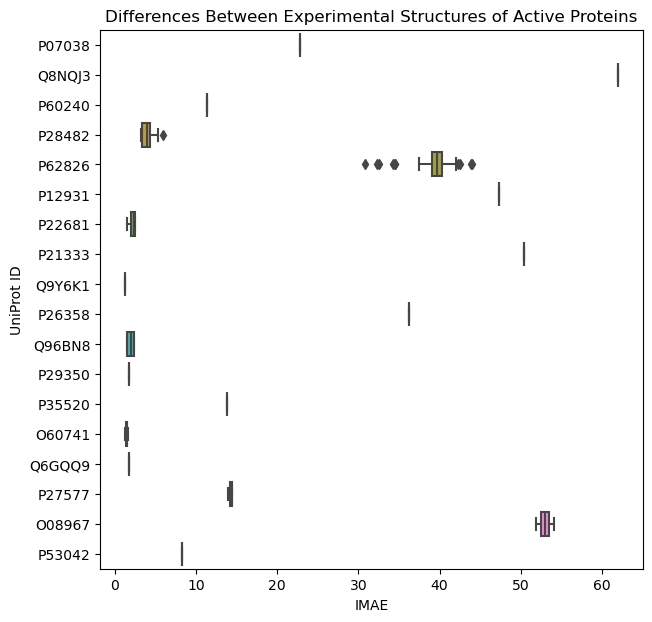

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.boxplot(data=active, x='2_comp', y='uniprot', ax=ax)
ax.set_xlabel('IMAE')
ax.set_ylabel('UniProt ID')
ax.set_title('Differences Between Experimental Structures of Active Proteins')

Text(0.5, 1.0, 'Differences Between Experimental Structures of Autoinhibited Proteins')

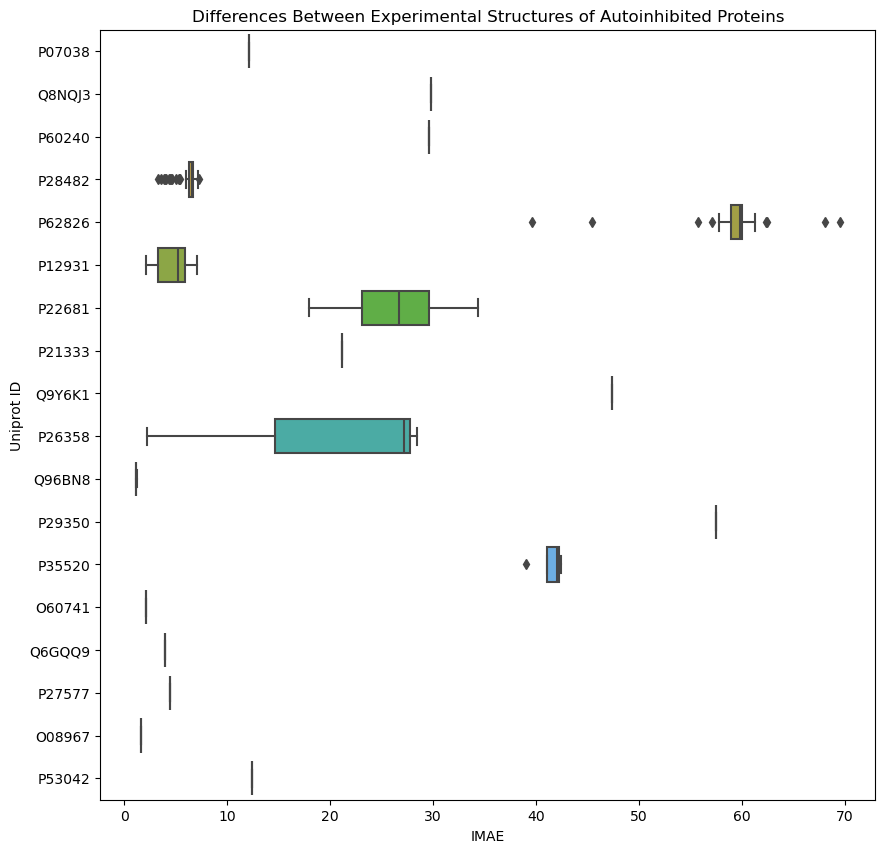

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.boxplot(data=auto, x='2_comp', y='uniprot', ax=ax)
ax.set_xlabel('IMAE')
ax.set_ylabel('Uniprot ID')
ax.set_title('Differences Between Experimental Structures of Autoinhibited Proteins')

In [9]:
# Look at the proteins with many different structures per state
prot = ['P62826', 'P12931', 'P22681', 'P26358', 'P28482', 'P35520']

many = df2[df2['uniprot'].isin(prot)]
print(len(many))
many.head()

257


,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes
25,P28482,1pme,173-196,"25-172,197-313",2.422,100.0,96.603774,1.220,6.639,Autoinhibited,Closed,Homo sapiens,['1998-06-08'],NaN
26,P28482,1tvo,173-196,"25-172,197-313",2.497,100.0,100.000000,1.523,6.633,Autoinhibited,Closed,Homo sapiens,['2004-06-30'],NaN
27,P28482,1wzy,173-196,"25-172,197-313",2.515,100.0,100.000000,1.768,6.306,Autoinhibited,Closed,Homo sapiens,['2005-03-10'],NaN
28,P28482,2y9q,173-196,"25-172,197-313",1.967,100.0,100.000000,1.261,4.431,Autoinhibited,Closed,HOMO SAPIENS,['2011-02-16'],NaN
29,P28482,3sa0,173-196,"25-172,197-313",3.340,100.0,98.867925,1.286,6.758,Autoinhibited,Closed,Homo sapiens,['2011-06-02'],NaN


In [10]:
def assign_bins(df, bin_size=3):
    bins_info = []

    for protein in df['uniprot'].unique():
        protein_df = df[df['uniprot'] == protein]
        min_val = protein_df['2_comp'].min()
        max_val = protein_df['2_comp'].max()
        bins = np.arange(min_val, max_val + bin_size, bin_size)
        labels = range(len(bins) - 1)

        protein_df['bin'] = pd.cut(protein_df['2_comp'], bins=bins, labels=labels, include_lowest=True)
        protein_df['bin_id'] = protein + '_' + protein_df['bin'].astype('str')

        bins_info.append(protein_df)

    return pd.concat(bins_info)

In [11]:
binned = assign_bins(df2)
binned.head()

/tmp/ipykernel_546131/1346576070.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin'] = pd.cut(protein_df['2_comp'], bins=bins, labels=labels, include_lowest=True)
/tmp/ipykernel_546131/1346576070.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin_id'] = protein + '_' + protein_df['bin'].astype('str')
/tmp/ipykernel_546131/1346576070.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes,bin,bin_id
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,Closed,"""Neurospora crassa""",['2002-08-21'],NaN,3,P07038_3
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-18'],“Phosphorylation of Ser913/Thr914 would distur...,0,P07038_0
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-19'],NaN,0,P07038_0
5,Q8NQJ3,2kb3,1-40,68-117,15.371,97.5,100.0,2.552,29.829,Autoinhibited,Closed,Corynebacterium glutamicum,['2008-11-20'],NaN,0,Q8NQJ3_0
6,Q8NQJ3,2kb4,1-40,68-117,30.770,100.0,100.0,2.450,61.982,Active,Open,Corynebacterium glutamicum,['2008-11-20'],NaN,10,Q8NQJ3_10


In [26]:
# Check P62826 really quickly, there's some weird stuff going on with one cluster fitting three different bins.
P62826 = binned[binned['uniprot'] == 'P62826']
groupedp = P62826.groupby('bin_id').apply(lambda x: x[x['2_comp'] == x['2_comp'].min()])

groupedp.head(9)

,,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes,bin,bin_id
bin_id,,,,,,,,,,,,,,,,,
P62826_0,144,P62826,1rrp,179-216,10-169,11.976,86.842105,100.000,1.377,30.840,Active,Closed,Homo sapiens,['1999-01-15'],NaN,0,P62826_0
P62826_1,142,P62826,1k5d,179-216,10-169,13.757,92.105263,100.000,2.235,34.225,Active,Closed,Homo sapiens,['2001-10-10'],NaN,1,P62826_1
P62826_10,230,P62826,7mnv,179-216,10-169,23.383,81.578947,99.375,4.625,61.043,Autoinhibited,Closed,Homo sapiens,['2021-05-01'],NaN,10,P62826_10
P62826_12,145,P62826,2mmc,179-216,10-169,28.197,100.000000,100.000,4.801,68.008,Autoinhibited,Closed,Homo sapiens,['2014-03-13'],NaN,12,P62826_12
P62826_2,231,P62826,7mnw,179-216,10-169,15.482,100.000000,100.000,1.258,37.459,Active,Closed,Homo sapiens,['2021-05-01'],NaN,2,P62826_2
P62826_3,201,P62826,6cit,179-216,10-169,16.150,94.736842,100.000,0.960,39.878,Active,Closed,Homo sapiens,['2018-02-25'],NaN,3,P62826_3
P62826_4,161,P62826,4haw,179-216,10-169,15.494,68.421053,100.000,1.109,43.889,Active,Closed,Homo sapiens,['2012-09-27'],NaN,4,P62826_4
P62826_8,172,P62826,5cj2,179-216,10-169,19.970,68.421053,99.375,4.586,55.712,Autoinhibited,Closed,Homo sapiens,['2015-07-13'],NaN,8,P62826_8
P62826_9,170,P62826,5cit,179-216,10-169,21.438,73.684211,100.000,4.847,58.062,Autoinhibited,Closed,Homo sapiens,['2015-07-13'],NaN,9,P62826_9


In [13]:
# We need only uniprot, pdb, state, conformation, and bin_id
binned_s = binned[['uniprot', 'pdb', 'state', 'conformation', 'bin_id']]

merge1 = pd.merge(binned_s, df1, on=['uniprot', 'pdb'], how='right')
merge1.head()

,uniprot,pdb,state,conformation,bin_id,cluster,region_1,region_2,complex_rmsd,1.0_aligned,...,2.2_aligned,2.2_comp,2.3_aligned,2.3_comp,1_aligned,1_comp,2_aligned,2_comp,af_state,af_conformation
0,O08967,2r09,Autoinhibited,Closed,O08967_0,U10-005,"251-265,383-395",77-206,17.274,0.0,...,0.0,0.0,0,0,3.704,36.530,1.183,33.607,Autoinhibited,Closed
1,O08967,2r09,Autoinhibited,Closed,O08967_0,031,"251-265,383-395",77-206,19.503,0.0,...,0.0,0.0,0,0,3.394,36.860,3.580,31.059,Autoinhibited,Closed
2,O08967,2r09,Autoinhibited,Closed,O08967_0,U10-001,"251-265,383-395",77-206,16.866,0.0,...,0.0,0.0,0,0,3.276,24.538,1.148,23.513,Autoinhibited,Closed
3,O08967,2r09,Autoinhibited,Closed,O08967_0,U100-004,"251-265,383-395",77-206,21.285,0.0,...,0.0,0.0,0,0,3.414,51.587,1.331,52.734,Autoinhibited,Closed
4,O08967,2r09,Autoinhibited,Closed,O08967_0,029,"251-265,383-395",77-206,12.546,0.0,...,0.0,0.0,0,0,3.296,22.383,4.080,23.212,Autoinhibited,Closed


So all of our best structures are from uniformly sampled MSAs. Let's see what happens without those in the mix.

44


Text(0.5, 0, 'IMAE')

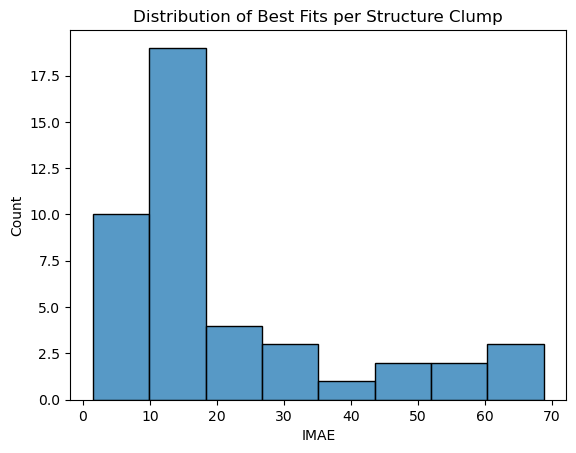

In [28]:
nou = merge1[~merge1['cluster'].str.contains('U')]

best2 = nou.groupby('bin_id').apply(lambda x: x[x['2_comp'] == x['2_comp'].min()])
print(len(best2))

sns.histplot(best2, x='2_comp')
plt.title('Distribution of Best Fits per Structure Clump')
plt.xlabel('IMAE')

In [21]:
acceptable2 = best2[best2['2_comp'] <= 3]
acceptable2.head(10)

,,uniprot,pdb,state,conformation,bin_id,cluster,region_1,region_2,complex_rmsd,1.0_aligned,...,2.2_aligned,2.2_comp,2.3_aligned,2.3_comp,1_aligned,1_comp,2_aligned,2_comp,af_state,af_conformation
bin_id,,,,,,,,,,,,,,,,,,,,,,
P28482_0,16018,P28482,5v62,Autoinhibited,Closed,P28482_0,139,173-196,"25-172,197-313",4.397,2.615,...,1.662,2.746,0,0,2.615,2.050,1.861,2.740,Autoinhibited,Closed
P62826_10,55025,P62826,7mo3,Autoinhibited,Closed,P62826_10,096,179-216,10-169,1.835,1.376,...,0.000,0.000,0,0,1.376,2.315,1.904,1.623,Autoinhibited,Closed
P62826_8,53135,P62826,5cj2,Autoinhibited,Closed,P62826_8,096,179-216,10-169,1.978,1.194,...,0.000,0.000,0,0,1.194,2.230,2.078,1.552,Autoinhibited,Closed
P62826_9,52883,P62826,5cit,Autoinhibited,Closed,P62826_9,096,179-216,10-169,1.887,1.037,...,0.000,0.000,0,0,1.037,2.721,1.981,1.466,Autoinhibited,Closed
Q96BN8_0,56306,Q96BN8,6sak,NaN,Closed,Q96BN8_0,013,330-340,129-341,3.333,1.012,...,0.000,0.000,0,0,1.012,4.697,3.229,1.756,NaN,NaN
